In [ ]:
!pip install rouge

In [ ]:
import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from rouge import Rouge

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/NLP-FinalProject/train (1).csv')

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/NLP-FinalProject/test (1).csv')

In [ ]:
train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
train_data = train_data.drop(['id'], axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.drop(['id'], axis=1)
test_data = test_data.reset_index(drop=True)

In [ ]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean_summaries = []
for summary in train_data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')

Cleaning Summaries Complete


In [ ]:
clean_texts = []
for text in train_data.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

Cleaning Texts Complete


In [ ]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:110000]
clean_df['summary'] = clean_summaries[:110000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  60.00719413677853
Total Coverage of rare words:  0.7458147584629847
Text Vocab:  133418


In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  70.11489659306625
Total Coverage of rare words:  2.4837378859339996
Summary Vocab:  29912


In [ ]:
maxlen_text = 800
maxlen_summ = 150

In [ ]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [ ]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [ ]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (99000, 800)
Target Values Shape (99000, 150)
Test Sequence (11000, 800)
Target Test Shape (11000, 150)


In [ ]:
embeding_index = {}
embed_dim = 50
with open('/content/drive/MyDrive/NLP-FinalProject/glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [ ]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [ ]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [ ]:
del embeding_index

In [ ]:
from tensorflow.keras.layers import Attention

In [ ]:
# Encoder
latent_dim = 128  # Or any other dimension you chose for your LSTM
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
enc_outputs, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_states = [Concatenate(axis=-1)([enc_fh, enc_bh]), Concatenate(axis=-1)([enc_fc, enc_bc])]

# Decoder
dec_input = Input(shape=(None,))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)

# Adjusting dimensions of the decoder embeddings to match the encoder outputs
dec_embed_out = TimeDistributed(Dense(latent_dim*2))(dec_embed)

# Attention Layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([dec_embed_out, enc_outputs])

# Concatenating attention output and decoder LSTM output
dec_concat_input = Concatenate(axis=-1, name='concat_layer')([dec_embed_out, attn_out])

# Decoder LSTM
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_concat_input, initial_state=enc_states)

# Output Layer
dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

In [ ]:
model = Model([enc_input, dec_input], dec_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 800)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 50)             1495600   ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 800, 50)              6670900   ['input_1[0][0]']             
                                                                                              

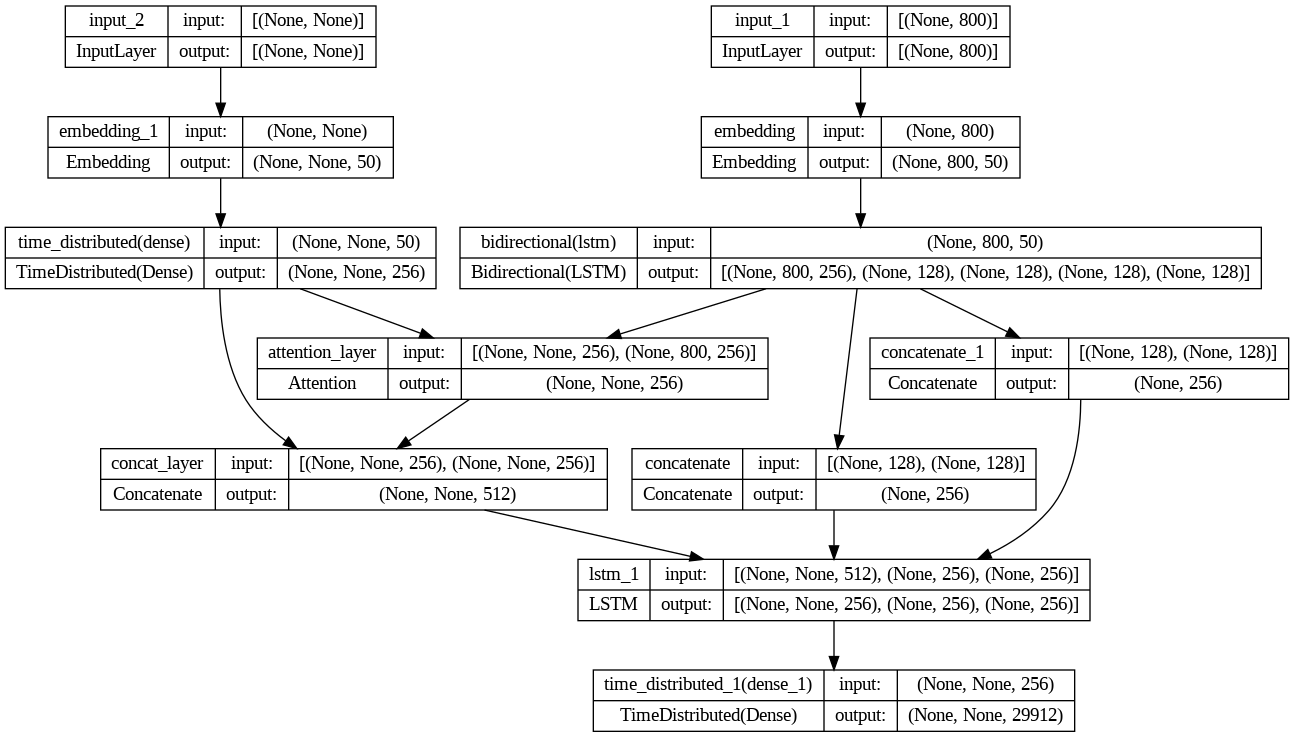

In [ ]:
plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/10
774/774 - 557s - loss: 2.6046 - val_loss: 2.4138 - 557s/epoch - 720ms/step
Epoch 2/10
774/774 - 542s - loss: 2.3806 - val_loss: 2.3397 - 542s/epoch - 700ms/step
Epoch 3/10
774/774 - 544s - loss: 2.3189 - val_loss: 2.2859 - 544s/epoch - 703ms/step
Epoch 4/10
774/774 - 544s - loss: 2.2727 - val_loss: 2.2465 - 544s/epoch - 703ms/step
Epoch 5/10
774/774 - 546s - loss: 2.2347 - val_loss: 2.2095 - 546s/epoch - 706ms/step
Epoch 6/10
774/774 - 548s - loss: 2.2023 - val_loss: 2.1807 - 548s/epoch - 708ms/step
Epoch 7/10
774/774 - 556s - loss: 2.1742 - val_loss: 2.1533 - 556s/epoch - 718ms/step
Epoch 8/10
774/774 - 558s - loss: 2.1490 - val_loss: 2.1309 - 558s/epoch - 721ms/step
Epoch 9/10
774/774 - 559s - loss: 2.1262 - val_loss: 2.1109 - 559s/epoch - 722ms/step
Epoch 10/10


In [ ]:
#history = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

In [ ]:
model.save('/content/drive/MyDrive/NLP-FinalProject/my_model_seq2seq_attention2.h5')  # Creates a HDF5 file 'my_model.h5'

In [ ]:
# Encoder Inference Model
enc_model = Model(inputs=enc_input, outputs=[enc_outputs, enc_fh, enc_fc, enc_bh, enc_bc])

# Preparing initial states for the decoder
dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))
dec_states_inputs = [dec_init_state_h, dec_init_state_c]

# Decoder setup for inference
dec_input = Input(shape=(None,))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_embed_out = TimeDistributed(Dense(latent_dim*2))(dec_embed)

# Attention mechanism
enc_output = Input(shape=(maxlen_text, latent_dim*2))  # Adjust the shape according to your encoder output
attn_out_inf = attn_layer([dec_embed_out, enc_output])
dec_concat_input = Concatenate(axis=-1, name='concat_layer')([dec_embed_out, attn_out_inf])

# Decoder LSTM
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_out, dec_h, dec_c = dec_lstm(dec_concat_input, initial_state=dec_states_inputs)

# Output layer
dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_out)

# Decoder Inference Model
dec_model = Model([dec_input, enc_output] + dec_states_inputs, [dec_output, dec_h, dec_c])


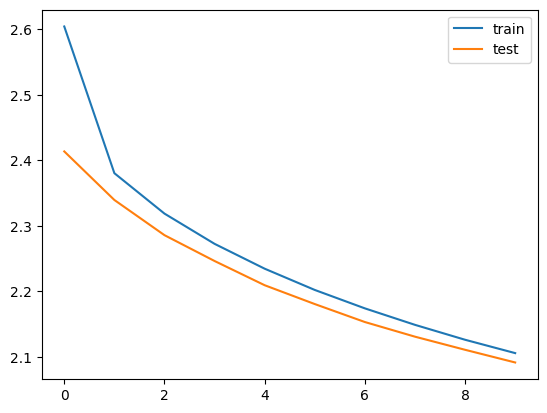

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
def generate_summary(input_seq):
    # Predicting the encoder states and outputs
    enc_outs, enc_fh, enc_fc, enc_bh, enc_bc = enc_model.predict(input_seq)
    states_values = [np.concatenate([enc_fh, enc_bh], axis=-1), np.concatenate([enc_fc, enc_bc], axis=-1)]

    # Initializing the first token (start token)
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        # Predicting the next token
        decoder_out, state_h, state_c = dec_model.predict([next_token, enc_outs] + states_values)
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        # Preparing next token
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        states_values = [state_h, state_c]
        count += 1

    return output_seq.strip()


In [ ]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
hyps = []
with open('/content/drive/MyDrive/NLP-FinalProject/result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(5000):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step


OSError: ignored

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.00022271508133966453,
  'p': 0.0007210600541584663,
  'f': 0.0003242268562988378},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.00022271508133966453,
  'p': 0.0007210600541584663,
  'f': 0.0003242268562988378}}